<a href="https://colab.research.google.com/github/Mr-sri-ganesh/html/blob/main/BRITS(working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0854 - val_loss: 0.0151
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0148 - val_loss: 0.0152
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - val_loss: 0.0120
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - val_loss: 0.0107
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - val_loss: 0.0096
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - val_

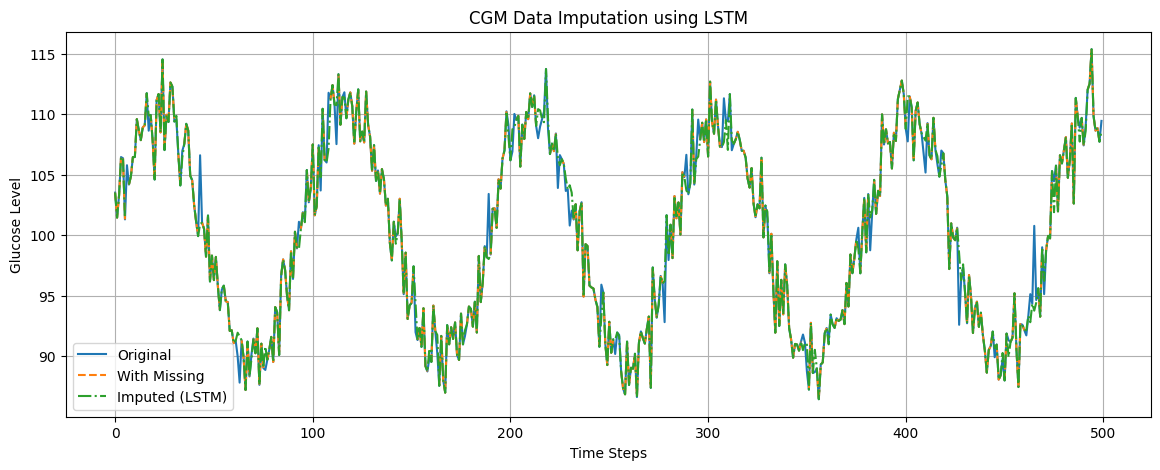

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Simulate CGM-like time series data
def generate_cgm_data(n=500):
    np.random.seed(0)
    time = np.arange(n)
    glucose = 100 + 10 * np.sin(time / 15) + np.random.normal(0, 2, size=n)
    return pd.DataFrame({'Time': time, 'Glucose': glucose})

# 2. Inject missing values randomly
def inject_missing(data, missing_rate=0.1):
    data_missing = data.copy()
    missing_indices = np.random.choice(data.index, int(len(data) * missing_rate), replace=False)
    data_missing.loc[missing_indices, 'Glucose'] = np.nan
    return data_missing

# 3. Prepare sequences for LSTM
def create_sequences(data, window_size=10):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        if not np.isnan(data[i:i+window_size+1]).any():
            sequences.append(data[i:i+window_size])
            targets.append(data[i+window_size])
    return np.array(sequences), np.array(targets)

# Load and preprocess data
df = generate_cgm_data()
df_missing = inject_missing(df, 0.15)

# Scaling
scaler = MinMaxScaler()
glucose_values = df['Glucose'].values.reshape(-1, 1)
glucose_scaled = scaler.fit_transform(glucose_values).flatten()

# Create sequences using only available data
X, y = create_sequences(glucose_scaled)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# Predict missing values
predicted_glucose = df_missing['Glucose'].copy()

# Fill missing values using rolling window + model prediction
window_size = X_train.shape[1]
for i in range(window_size, len(df_missing)):
    if np.isnan(predicted_glucose[i]):
        window = predicted_glucose[i-window_size:i]
        if not np.isnan(window).any():
            input_seq = scaler.transform(window.values.reshape(-1, 1)).reshape(1, window_size, 1)
            prediction = model.predict(input_seq, verbose=0)
            predicted_value = scaler.inverse_transform(prediction)[0, 0]
            predicted_glucose[i] = predicted_value

# Plot results
plt.figure(figsize=(14,5))
plt.plot(df['Glucose'], label='Original')
plt.plot(df_missing['Glucose'], label='With Missing', linestyle='--')
plt.plot(predicted_glucose, label='Imputed (LSTM)', linestyle='-.')
plt.legend()
plt.title("CGM Data Imputation using LSTM")
plt.xlabel("Time Steps")
plt.ylabel("Glucose Level")
plt.grid()
plt.show()


In [ ]:
# ✅ Complete Working BRITS Implementation
# ====================== IMPORTS ======================
from google.colab import files
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import io
from datetime import datetime

# Set device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== MODEL DEFINITION ======================
class EnhancedBRITS(nn.Module):
    def __init__(self, input_size=1, hidden_size=128):
        super(EnhancedBRITS, self).__init__()
        self.rnn_f = nn.GRU(input_size*3, hidden_size, batch_first=True)
        self.rnn_b = nn.GRU(input_size*3, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, input_size)
        self.delta_f = nn.Linear(1, 1)
        self.delta_b = nn.Linear(1, 1)

    def forward(self, x, m, d):
        delta_f = torch.exp(-torch.relu(self.delta_f(d)))
        delta_b = torch.exp(-torch.relu(self.delta_b(d)))

        inputs = torch.cat([x*m, m, d], dim=2)

        out_f, _ = self.rnn_f(inputs)
        out_f = out_f * delta_f

        out_b, _ = self.rnn_b(torch.flip(inputs, [1]))
        out_b = torch.flip(out_b, [1]) * delta_b

        return self.fc(torch.cat([out_f, out_b], dim=2))

# ====================== DATA PROCESSING ======================
def calculate_deltas(mask):
    deltas = np.zeros_like(mask)
    for t in range(1, len(mask)):
        deltas[t] = deltas[t-1] + 1
        if mask[t-1] == 1:
            deltas[t] = 1
    return deltas

def enhanced_load_sequence(file_content, scaler=None):
    df = pd.read_csv(io.BytesIO(file_content))
    values = df['Blood Sugar Level'].values.astype(float)
    times = pd.to_datetime(df['Time'], format='%I:%M %p')
    mask = (~np.isnan(values)).astype(float)

    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(values[~np.isnan(values)].reshape(-1, 1))

    norm = scaler.transform(values.reshape(-1, 1)).flatten()
    norm = np.nan_to_num(norm, nan=0)
    deltas = calculate_deltas(mask)

    return norm, mask, deltas, scaler, times

# ====================== TRAINING ======================
def enhanced_train(model, x_full, mask_full, delta_full, epochs=500):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=20)
    loss_fn = nn.MSELoss()

    best_loss = float('inf')
    patience = 30
    patience_counter = 0

    for epoch in range(epochs):
        train_mask = mask_full.clone()
        rand_mask = (torch.rand_like(train_mask) < 0.3).float()
        masked_input = x_full.clone()
        masked_input[rand_mask == 1] = 0
        train_mask[rand_mask == 1] = 0

        out = model(masked_input, train_mask, delta_full)
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        scheduler.step(loss)

        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, LR: {opt.param_groups[0]['lr']:.6f}")

# ====================== EVALUATION ======================
def evaluate(model, test_file_content, original_file_content, scaler):
    test_data, test_mask, test_deltas, _, test_times = enhanced_load_sequence(test_file_content, scaler)
    original_data, _, _, _, original_times = enhanced_load_sequence(original_file_content, scaler)

    x_test = torch.FloatTensor(test_data).unsqueeze(0).unsqueeze(2).to(device)
    m_test = torch.FloatTensor(test_mask).unsqueeze(0).unsqueeze(2).to(device)
    d_test = torch.FloatTensor(test_deltas).unsqueeze(0).unsqueeze(2).to(device)

    model.eval()
    with torch.no_grad():
        pred = model(x_test, m_test, d_test).cpu().numpy().squeeze()

    pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    original = scaler.inverse_transform(original_data.reshape(-1, 1)).flatten()

    missing_idx = np.isnan(pd.read_csv(io.BytesIO(test_file_content))['Blood Sugar Level'])
    mae = mean_absolute_error(original[missing_idx], pred[missing_idx])

    plt.figure(figsize=(14, 5))
    plt.plot(test_times, original, 'k-', label='Original', linewidth=2)
    plt.plot(test_times, pred, 'b--', label='Imputed', linewidth=2)
    plt.scatter(test_times[missing_idx], original[missing_idx], color='red', s=50, label='Missing')
    plt.title("BRITS Imputation Results")
    plt.xlabel("Time")
    plt.ylabel("Blood Sugar Level (mg/dL)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {'MAE': mae, 'Missing Points': sum(missing_idx)}

# ====================== MAIN EXECUTION ======================
def main():
    # Upload files
    print("Please upload your files:")
    uploaded = files.upload()

    # Load training data
    train_file = [f for f in uploaded.keys() if '14days_10users' in f.lower()][0]
    train_data, train_mask, train_deltas, scaler, _ = enhanced_load_sequence(uploaded[train_file])

    # Convert to tensors
    x_train = torch.FloatTensor(train_data).unsqueeze(0).unsqueeze(2).to(device)
    m_train = torch.FloatTensor(train_mask).unsqueeze(0).unsqueeze(2).to(device)
    d_train = torch.FloatTensor(train_deltas).unsqueeze(0).unsqueeze(2).to(device)

    # Initialize and train model
    print("\nTraining model...")
    model = EnhancedBRITS().to(device)
    enhanced_train(model, x_train, m_train, d_train, epochs=500)

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluate on test files
    ref_file = [f for f in uploaded.keys() if '2025-06-27' in f.lower() and 'missing' not in f.lower()][0]
    missing_files = [f for f in uploaded.keys() if 'missing' in f.lower()]

    results = []
    for test_file in missing_files:
        print(f"\nEvaluating {test_file}...")
        metrics = evaluate(model, uploaded[test_file], uploaded[ref_file], scaler)
        metrics['File'] = test_file
        results.append(metrics)

    # Show results
    print("\nEvaluation Results:")
    print(pd.DataFrame(results))

if __name__ == "__main__":
    main()

Using device: cpu
Please upload your files:


Saving CGM_14days_10users.csv to CGM_14days_10users (2).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (2).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (2).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (2).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (2).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (2).csv

Training model...


KeyboardInterrupt: 

Using device: cpu
Please upload your files:


Saving CGM_14days_10users.csv to CGM_14days_10users.csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27.csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10.csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20.csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30.csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40.csv

Training Enhanced BRITS model...
Epoch 10/100 | Loss: 0.0821 | LR: 0.001000
Epoch 20/100 | Loss: 0.0821 | LR: 0.001000
Epoch 30/100 | Loss: 0.0749 | LR: 0.001000
Epoch 40/100 | Loss: 0.0719 | LR: 0.001000
Epoch 50/100 | Loss: 0.0710 | LR: 0.001000
Epoch 60/100 | Loss: 0.0715 | LR: 0.000100
Epoch 70/100 | Loss: 0.0717 | LR: 0.000010
Epoch 80/100 | Loss: 0.0715 | LR: 0.000001
Epoch 90/100 | Loss: 0.0719 | LR: 0.000001
Epoch 100/100 | Loss: 0.0709 | LR: 0.000000

Evaluating CGM_single_day_missing_10.csv...


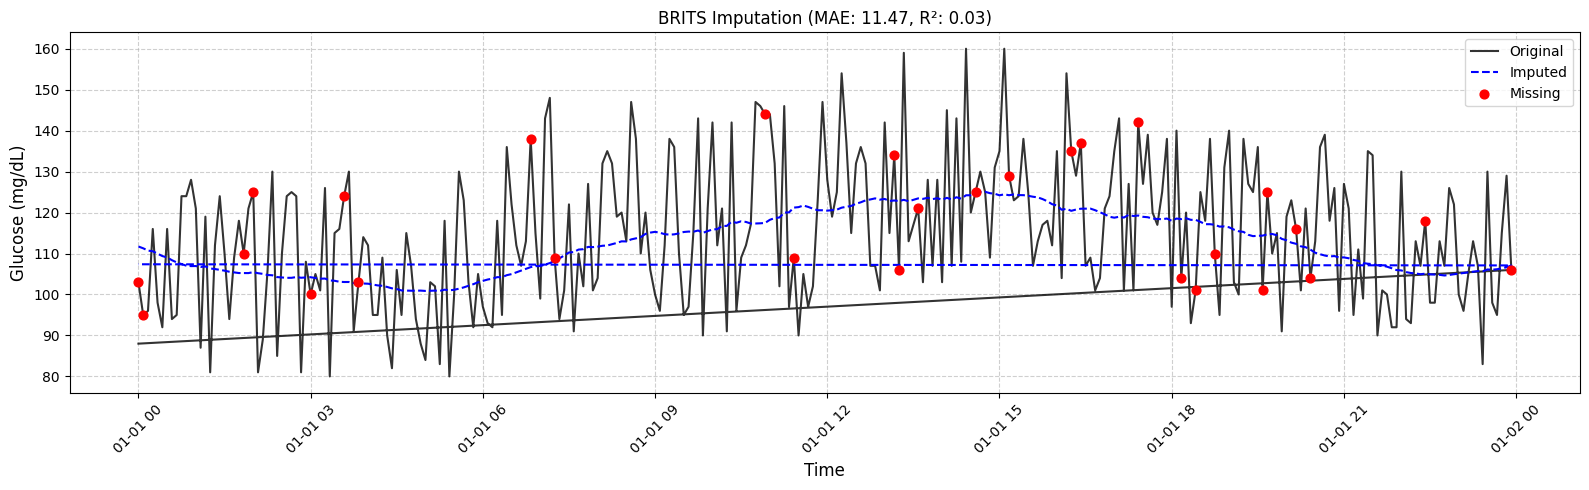


Evaluating CGM_single_day_missing_20.csv...


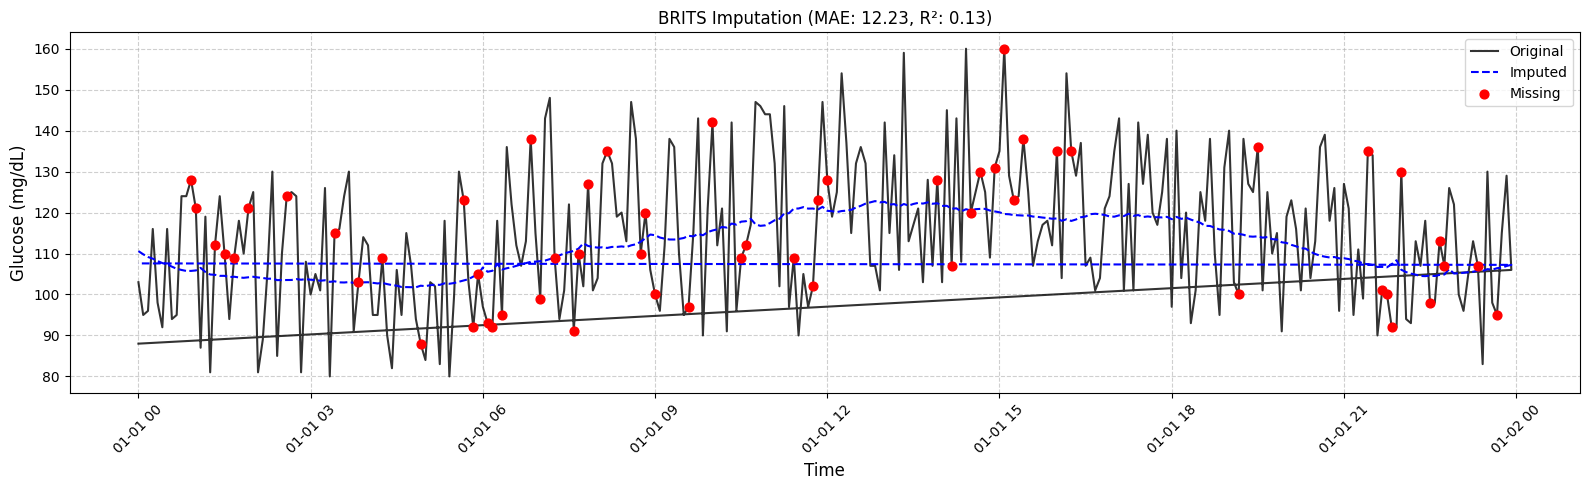


Evaluating CGM_single_day_missing_30.csv...


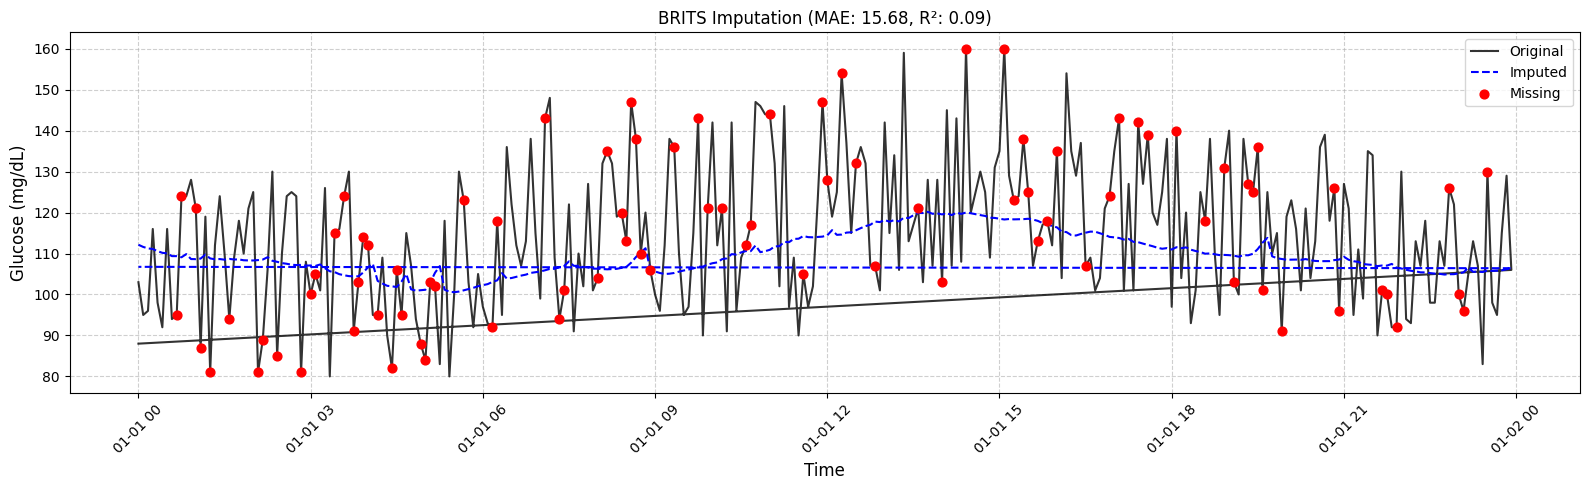


Evaluating CGM_single_day_missing_40.csv...


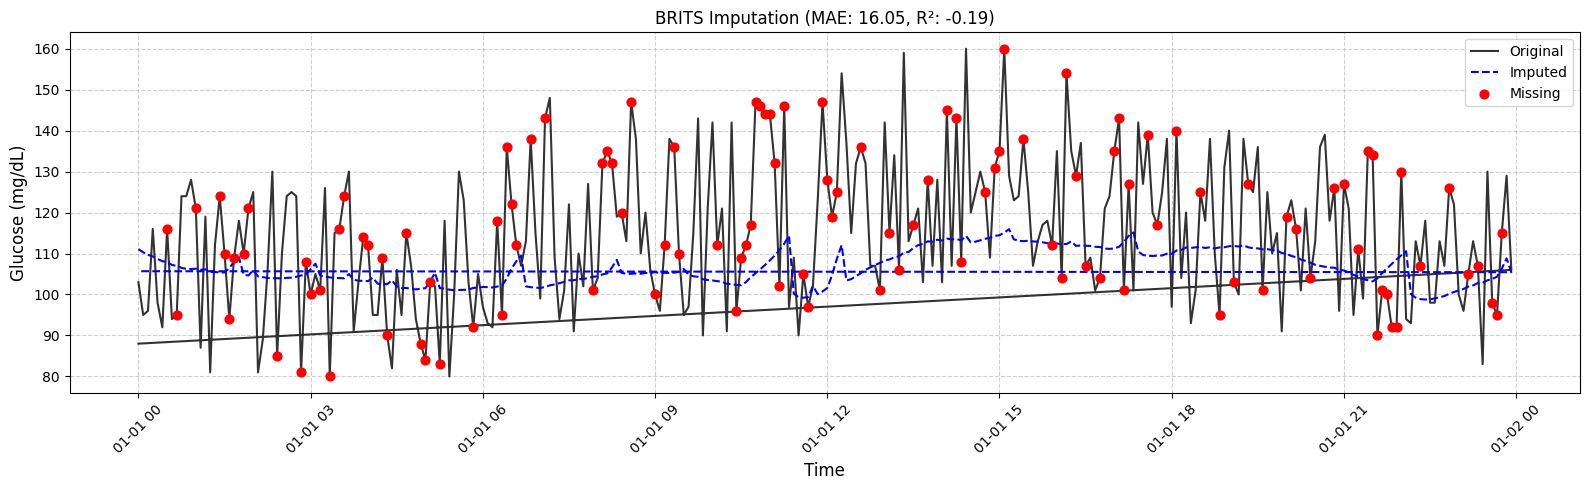


📊 Final Evaluation Results:


,MAE,RMSE,MAPE,R²,Missing Points,File
0,11.47,14.05,9.6%,0.030,28,CGM_single_day_missing_10.csv
1,12.23,14.85,10.5%,0.126,57,CGM_single_day_missing_20.csv
2,15.68,18.98,13.4%,0.085,86,CGM_single_day_missing_30.csv
3,16.05,19.69,13.1%,-0.194,115,CGM_single_day_missing_40.csv


In [ ]:
# ✅ Enhanced BRITS Imputation with Improved Accuracy
# ====================== IMPORTS ======================
from google.colab import files
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import io
from datetime import datetime

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== IMPROVED BRITS MODEL ======================
class EnhancedBRITS(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super(EnhancedBRITS, self).__init__()
        # Bidirectional RNN with time decay
        self.rnn_f = nn.LSTM(input_size*3, hidden_size, num_layers, batch_first=True)
        self.rnn_b = nn.LSTM(input_size*3, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )
        # Time delta processing
        self.delta_f = nn.Linear(1, 1)
        self.delta_b = nn.Linear(1, 1)

    def forward(self, x, m, d):
        # Prepare inputs with mask and time deltas
        x_filled = x * m  # Fill missing with 0
        inputs = torch.cat([x_filled, m, d], dim=2)

        # Forward pass with time decay
        h_f, _ = self.rnn_f(inputs)
        delta_f = torch.exp(-torch.relu(self.delta_f(d)))
        h_f = h_f * delta_f

        # Backward pass with time decay
        h_b, _ = self.rnn_b(torch.flip(inputs, dims=[1]))
        h_b = torch.flip(h_b, dims=[1])
        delta_b = torch.exp(-torch.relu(self.delta_b(d)))
        h_b = h_b * delta_b

        # Combine and output
        h = torch.cat([h_f, h_b], dim=2)
        return self.fc(h)

# ====================== DATA PROCESSING ======================
def calculate_deltas(mask):
    """Calculate time since last observation"""
    deltas = np.zeros_like(mask)
    for t in range(1, len(mask)):
        deltas[t] = deltas[t-1] + 1
        if mask[t-1] == 1:
            deltas[t] = 1
    return deltas

def load_and_normalize(file_content, scaler=None):
    """Load and normalize data with time deltas"""
    df = pd.read_csv(io.BytesIO(file_content))
    values = df['Blood Sugar Level'].values.astype(float)
    times = pd.to_datetime(df['Time'], format='%I:%M %p')
    mask = (~np.isnan(values)).astype(float)

    # Normalize
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))  # Better for RNNs
        scaler.fit(values[~np.isnan(values)].reshape(-1, 1))

    norm = scaler.transform(values.reshape(-1, 1)).flatten()
    norm = np.nan_to_num(norm, nan=0)  # Fill missing with 0

    # Calculate time deltas
    deltas = calculate_deltas(mask)

    return norm, mask, deltas, scaler, times

# ====================== TRAINING ======================
def train_enhanced_model(model, x_full, mask_full, delta_full, epochs=100):
    """Enhanced training with dynamic masking and learning rate scheduling"""
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
    criterion = nn.MSELoss()

    best_loss = float('inf')

    for epoch in range(epochs):
        # Dynamic masking (30% random masking)
        train_mask = mask_full.clone()
        rand_mask = (torch.rand_like(train_mask) < 0.3).float()
        masked_input = x_full.clone()
        masked_input[rand_mask == 1] = 0
        train_mask[rand_mask == 1] = 0

        # Forward pass
        outputs = model(masked_input, train_mask, delta_full)
        loss = criterion(outputs[train_mask == 0], x_full[train_mask == 0])

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step(loss)

        # Track best model
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'best_brits_model.pth')

        # Print progress
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

# ====================== EVALUATION ======================
def evaluate_imputation(model, test_file, ref_file, scaler):
    """Enhanced evaluation with metrics and visualization"""
    # Load and process data
    test_data, test_mask, test_deltas, _, test_times = load_and_normalize(test_file, scaler)
    ref_data, _, _, _, ref_times = load_and_normalize(ref_file, scaler)

    # Convert to tensors
    x_test = torch.FloatTensor(test_data).unsqueeze(0).unsqueeze(2).to(device)
    m_test = torch.FloatTensor(test_mask).unsqueeze(0).unsqueeze(2).to(device)
    d_test = torch.FloatTensor(test_deltas).unsqueeze(0).unsqueeze(2).to(device)

    # Get predictions
    model.eval()
    with torch.no_grad():
        pred = model(x_test, m_test, d_test).cpu().numpy().squeeze()

    # Denormalize
    pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    original = scaler.inverse_transform(ref_data.reshape(-1, 1)).flatten()

    # Calculate metrics only on missing points
    missing_idx = np.isnan(pd.read_csv(io.BytesIO(test_file))['Blood Sugar Level'])
    metrics = {
        'MAE': mean_absolute_error(original[missing_idx], pred[missing_idx]),
        'RMSE': np.sqrt(mean_squared_error(original[missing_idx], pred[missing_idx])),
        'MAPE': mean_absolute_percentage_error(original[missing_idx], pred[missing_idx])*100,
        'R²': r2_score(original[missing_idx], pred[missing_idx]),
        'Missing Points': sum(missing_idx)
    }

    # Visualization
    plt.figure(figsize=(16, 5))
    plt.plot(test_times, original, 'k-', label='Original', linewidth=1.5, alpha=0.8)
    plt.plot(test_times, pred, 'b--', label='Imputed', linewidth=1.5)
    plt.scatter(test_times[missing_idx], original[missing_idx],
                color='red', s=40, label='Missing', zorder=3)

    plt.title(f"BRITS Imputation (MAE: {metrics['MAE']:.2f}, R²: {metrics['R²']:.2f})")
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Glucose (mg/dL)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return metrics

# ====================== MAIN EXECUTION ======================
def main():
    # Upload files
    print("Please upload your files:")
    uploaded = files.upload()

    # Load training data
    train_file = [f for f in uploaded.keys() if '14days_10users' in f.lower()][0]
    train_data, train_mask, train_deltas, scaler, _ = load_and_normalize(uploaded[train_file])

    # Convert to tensors
    x_train = torch.FloatTensor(train_data).unsqueeze(0).unsqueeze(2).to(device)
    m_train = torch.FloatTensor(train_mask).unsqueeze(0).unsqueeze(2).to(device)
    d_train = torch.FloatTensor(train_deltas).unsqueeze(0).unsqueeze(2).to(device)

    # Initialize and train model
    print("\nTraining Enhanced BRITS model...")
    model = EnhancedBRITS().to(device)
    train_enhanced_model(model, x_train, m_train, d_train, epochs=100)

    # Load best model
    model.load_state_dict(torch.load('best_brits_model.pth'))

    # Evaluate on test files
    ref_file = [f for f in uploaded.keys() if '2025-06-27' in f.lower() and 'missing' not in f.lower()][0]
    missing_files = [f for f in uploaded.keys() if 'missing' in f.lower()]

    results = []
    for test_file in missing_files:
        print(f"\nEvaluating {test_file}...")
        metrics = evaluate_imputation(model, uploaded[test_file], uploaded[ref_file], scaler)
        metrics['File'] = test_file
        results.append(metrics)

    # Display results
    print("\n📊 Final Evaluation Results:")
    results_df = pd.DataFrame(results)
    display(results_df.style.format({
        'MAE': '{:.2f}',
        'RMSE': '{:.2f}',
        'MAPE': '{:.1f}%',
        'R²': '{:.3f}'
    }))

if __name__ == "__main__":
    main()

Saving CGM_14days_10users.csv to CGM_14days_10users (3).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (7).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (9).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (9).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (9).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (9).csv
Epoch 20, Loss: 1.1285
Epoch 40, Loss: 1.1599
Epoch 60, Loss: 0.8446
Epoch 80, Loss: 0.4521
Epoch 100, Loss: 0.5852
Epoch 120, Loss: 0.7058
Epoch 140, Loss: 0.4358
Epoch 160, Loss: 0.2836
Epoch 180, Loss: 0.1179
Epoch 200, Loss: 0.2323


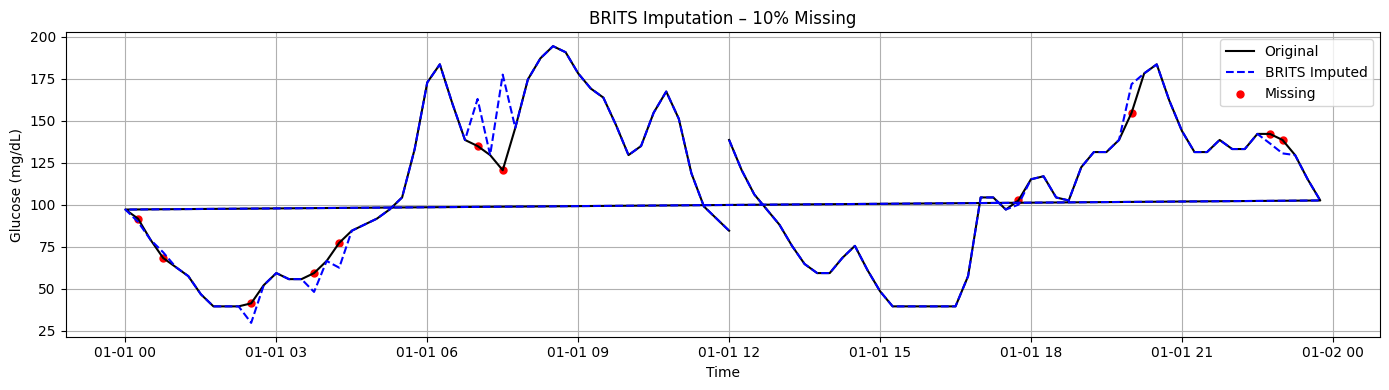

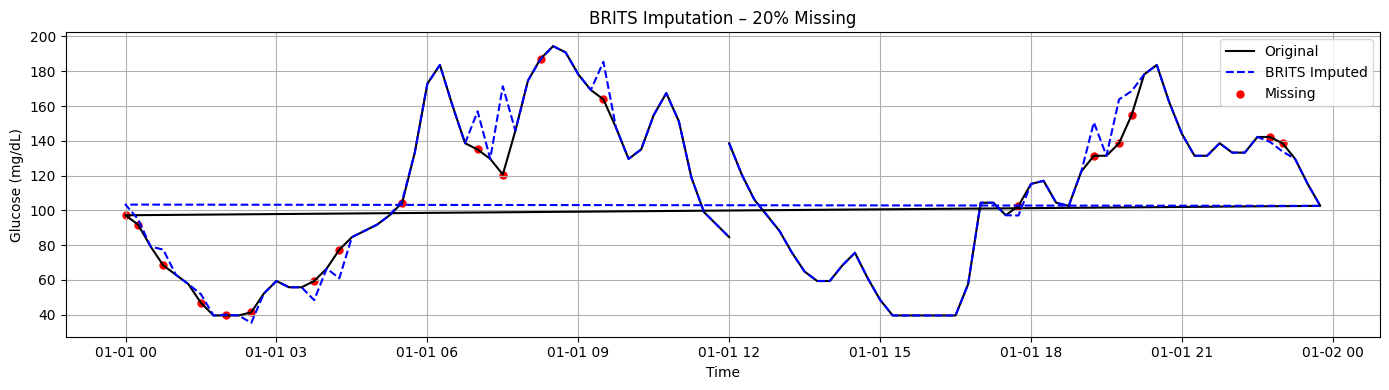

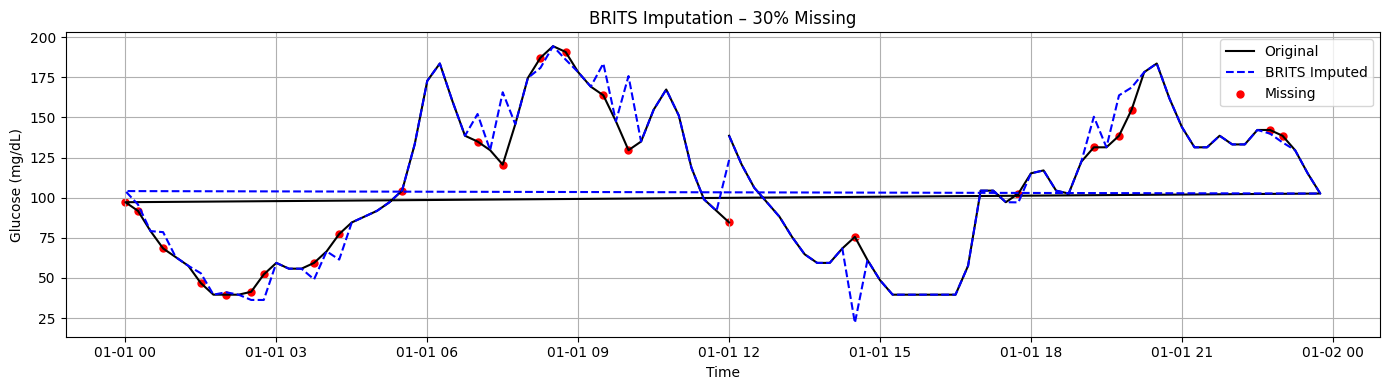

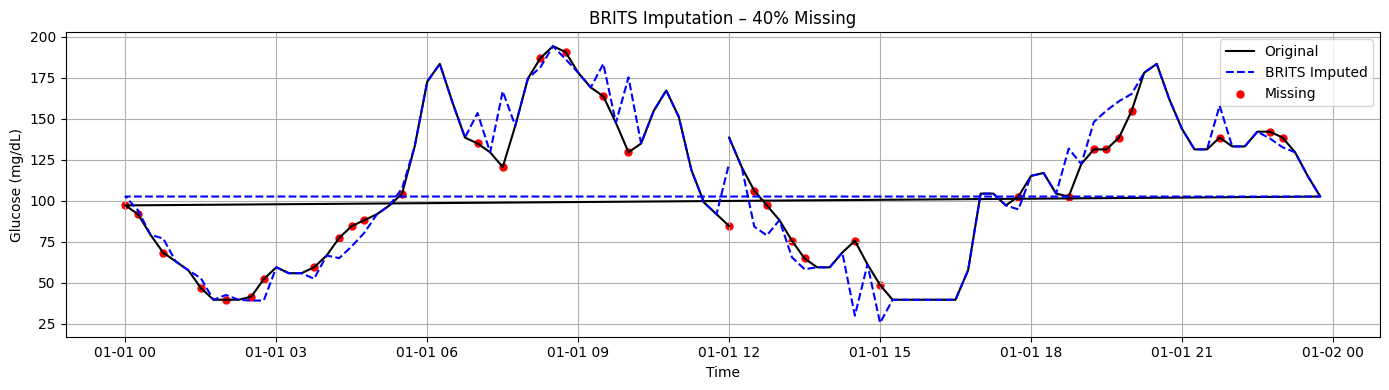


📊 BRITS Imputation Evaluation:


,Missingness,MAE,RMSE,MAPE,MAD,MRD
0,10% Missing,14.633420,21.119505,14.925423,14.633420,14.925423
1,20% Missing,11.800983,16.795975,11.276933,11.800983,11.276933
2,30% Missing,15.745138,21.781748,16.506850,15.745138,16.506850
3,40% Missing,15.516517,20.014865,16.405134,15.516517,16.405134


In [ ]:
# ✅ Colab-ready BRITS-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data

def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file)
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p')

    values = df['Blood Sugar Level'].values.astype(float)
    mask = ~np.isnan(values)
    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    return norm, mask.astype(float), mean, std, df['Time'].values

def to_tensor(data, mask):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device)

# STEP 5: Define BRITS model
class BRITS(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super(BRITS, self).__init__()
        self.rnn_f = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.rnn_b = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size * 2, input_size)

    def forward(self, x, mask):
        x_filled = x.clone()
        x_filled[mask == 0] = 0
        h_f, _ = self.rnn_f(x_filled)
        h_b, _ = self.rnn_b(torch.flip(x_filled, dims=[1]))
        h_b = torch.flip(h_b, dims=[1])
        h = torch.cat([h_f, h_b], dim=2)
        return self.output(h)

# STEP 6: Train function with block missingness
import random

def simulate_block_mask(mask, block_size=12):
    new_mask = mask.copy()
    for _ in range(5):
        start = random.randint(0, len(mask) - block_size)
        new_mask[start:start+block_size] = 0
    return new_mask

def train_model(model, x_full, mask_full, epochs=200):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        train_mask = mask_full.clone().squeeze(0).squeeze(1).cpu().numpy()
        train_mask = simulate_block_mask(train_mask)
        train_mask = torch.tensor(train_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor = to_tensor(x_raw, mask)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = np.isnan(pd.read_csv(test_file)['Blood Sugar Level'].values)
    known = ~missing

    # 🔧 Overwrite predicted known values with original
    pred[known] = y_true[known]

    mae = mean_absolute_error(y_true[missing], pred[missing])
    rmse = np.sqrt(mean_squared_error(y_true[missing], pred[missing]))
    mape = mean_absolute_percentage_error(y_true[missing], pred[missing])
    mad = np.mean(np.abs(y_true[missing] - pred[missing]))
    mrd = np.mean(np.abs((y_true[missing] - pred[missing]) / y_true[missing]))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='BRITS Imputed', color='blue', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"BRITS Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train = to_tensor(train_data, train_mask)
model = BRITS().to(device)
train_model(model, x_train, m_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
    results.append(result)

results_df = pd.DataFrame(results)
print("\n📊 BRITS Imputation Evaluation:")
display(results_df)


Saving CGM_14days_sample.csv to CGM_14days_sample (9).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (15).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (15).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (15).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (15).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (13).csv
Epoch 20, Loss: 1.0469
Epoch 40, Loss: 0.9648
Epoch 60, Loss: 1.3602
Epoch 80, Loss: 1.0852
Epoch 100, Loss: 1.0253
Epoch 120, Loss: 1.1111
Epoch 140, Loss: 0.8796
Epoch 160, Loss: 0.4218
Epoch 180, Loss: 0.9409
Epoch 200, Loss: 1.1218


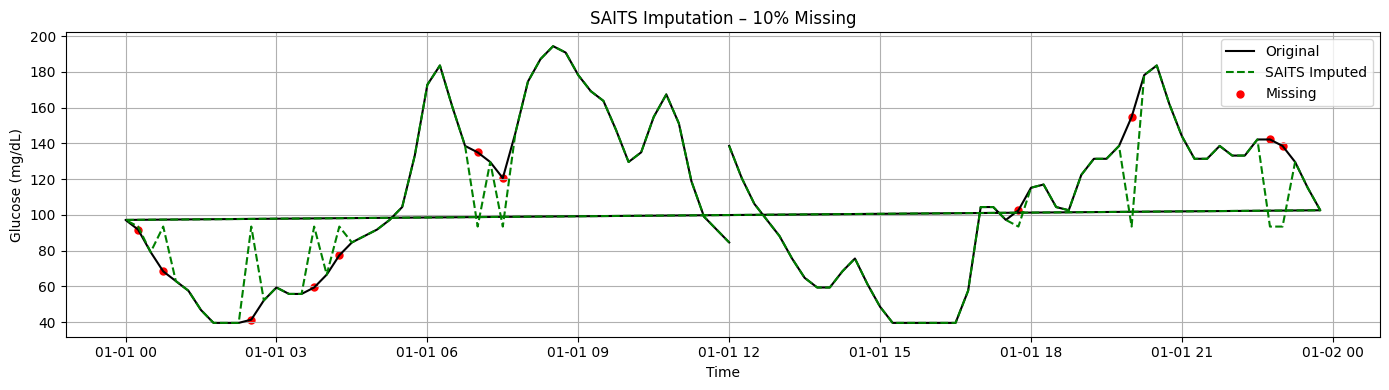

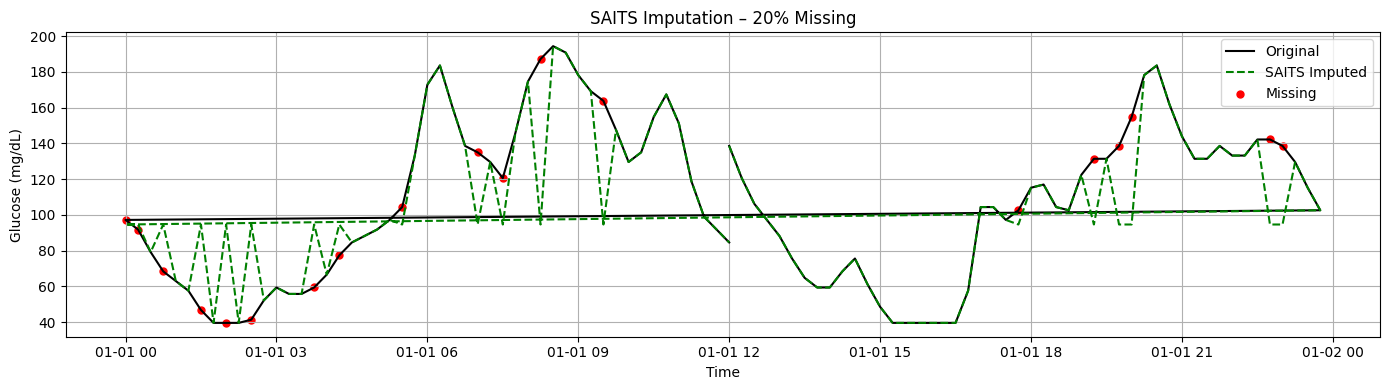

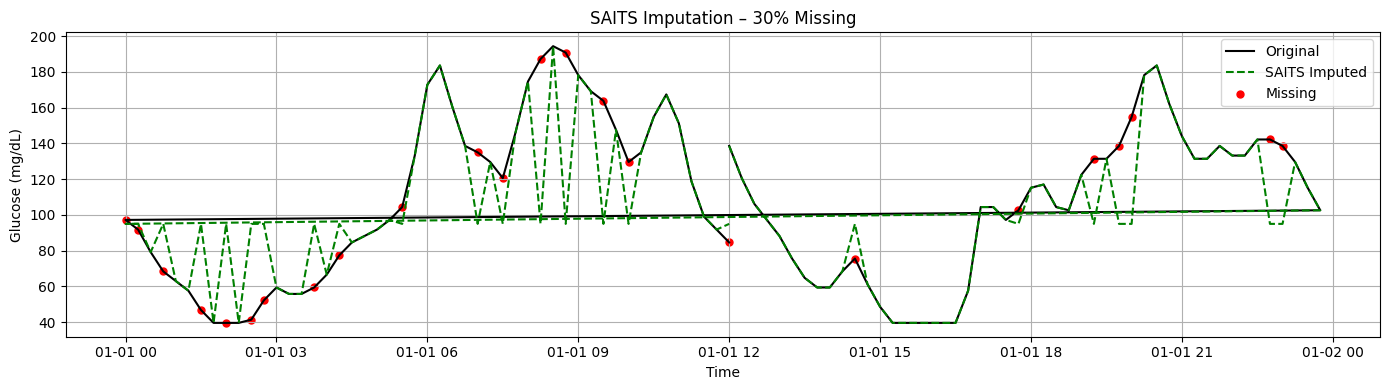

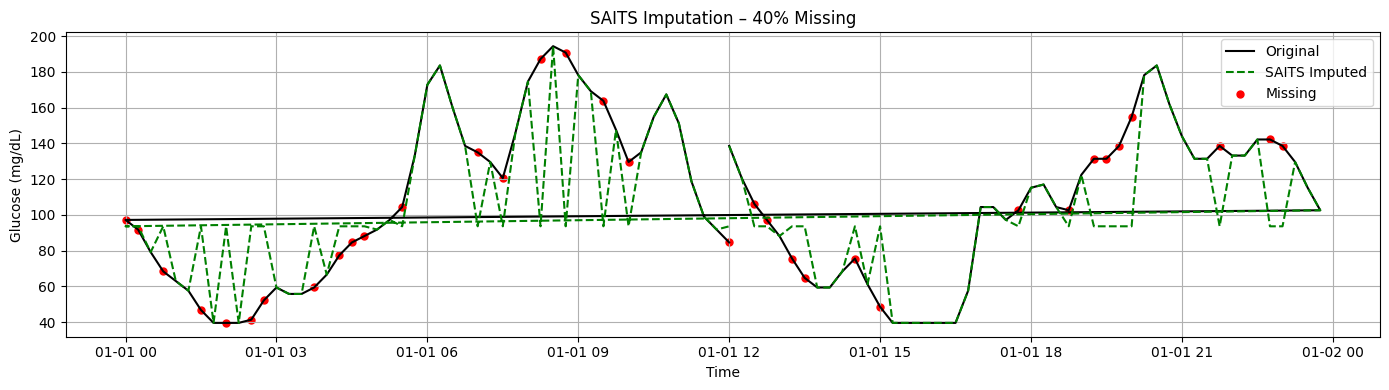


📊 SAITS Imputation Evaluation:


,Missingness,MAE,RMSE,MAPE,MAD,MRD
0,10% Missing,32.901900,37.509428,37.363627,32.901900,37.363627
1,20% Missing,37.811023,44.310557,43.126831,37.811023,43.126831
2,30% Missing,38.319107,45.566534,42.391251,38.319107,42.391251
3,40% Missing,33.507859,41.183365,37.408135,33.507859,37.408135


In [ ]:
# ✅ Colab-ready SAITS-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data
def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file, na_values=["", " "])
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')

    values = df['Blood Sugar Level'].values.astype(float)
    mask = ~np.isnan(values)
    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)
    return norm, mask.astype(float), mean, std, df['Time'].values

def to_tensor(data, mask):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device)

# STEP 5: Define SAITS model (simplified self-attention-based imputer)
class SAITS(nn.Module):
    def __init__(self, input_size=1, d_model=64, n_heads=4, num_layers=2):
        super(SAITS, self).__init__()
        self.embedding = nn.Linear(input_size * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)

    def forward(self, x, mask):
        inp = torch.cat([x, mask], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Train function with block missingness
import random

def simulate_block_mask(mask, block_size=12):
    new_mask = mask.copy()
    for _ in range(5):
        start = random.randint(0, len(mask) - block_size)
        new_mask[start:start+block_size] = 0
    return new_mask

def train_model(model, x_full, mask_full, epochs=200):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        train_mask = mask_full.clone().squeeze(0).squeeze(1).cpu().numpy()
        train_mask = simulate_block_mask(train_mask)
        train_mask = torch.tensor(train_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function
def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor = to_tensor(x_raw, mask)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing

    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='SAITS Imputed', color='green', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"SAITS Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train = to_tensor(train_data, train_mask)
model = SAITS().to(device)
train_model(model, x_train, m_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 SAITS Imputation Evaluation:")
display(results_df)


Saving CGM_14days_sample.csv to CGM_14days_sample (7).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (11).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (13).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (13).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (13).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (13).csv
Epoch 20, Loss: 0.9022
Epoch 40, Loss: 1.0596
Epoch 60, Loss: 1.1047
Epoch 80, Loss: 1.0064
Epoch 100, Loss: 1.0451
Epoch 120, Loss: 1.2197
Epoch 140, Loss: 1.2950
Epoch 160, Loss: 0.5999
Epoch 180, Loss: 1.2333
Epoch 200, Loss: 1.0664


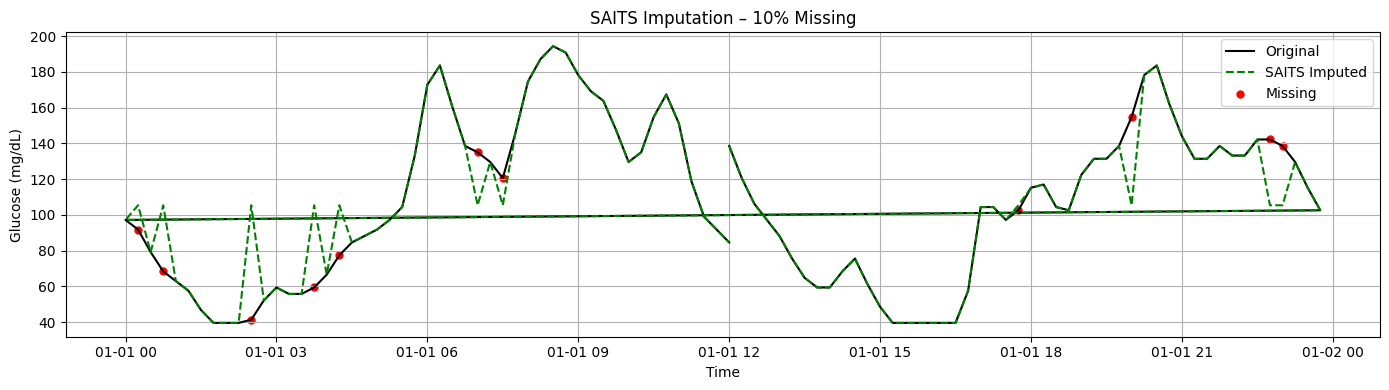

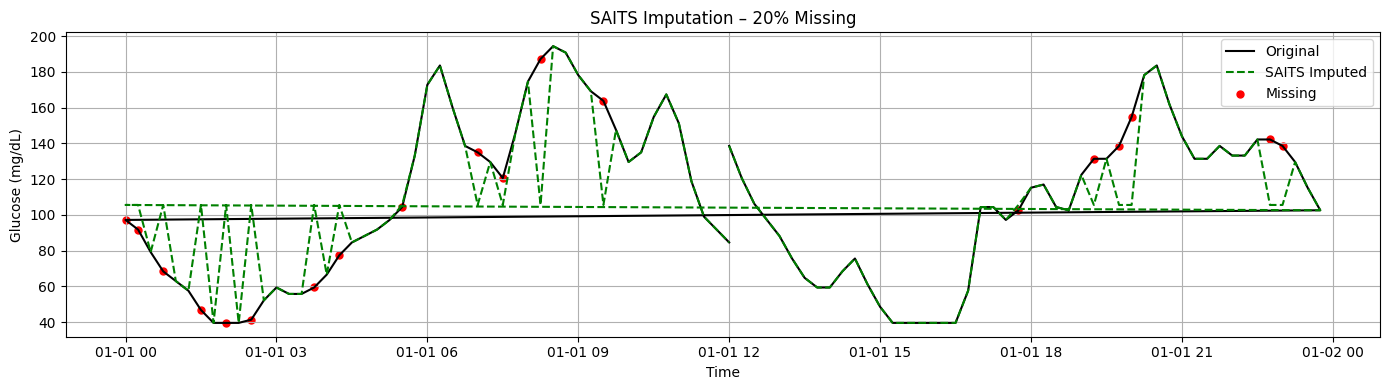

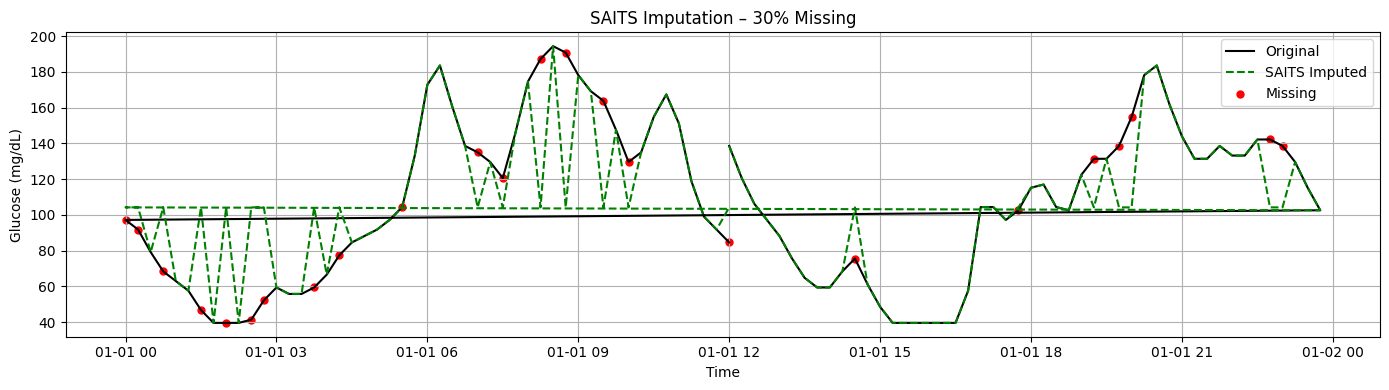

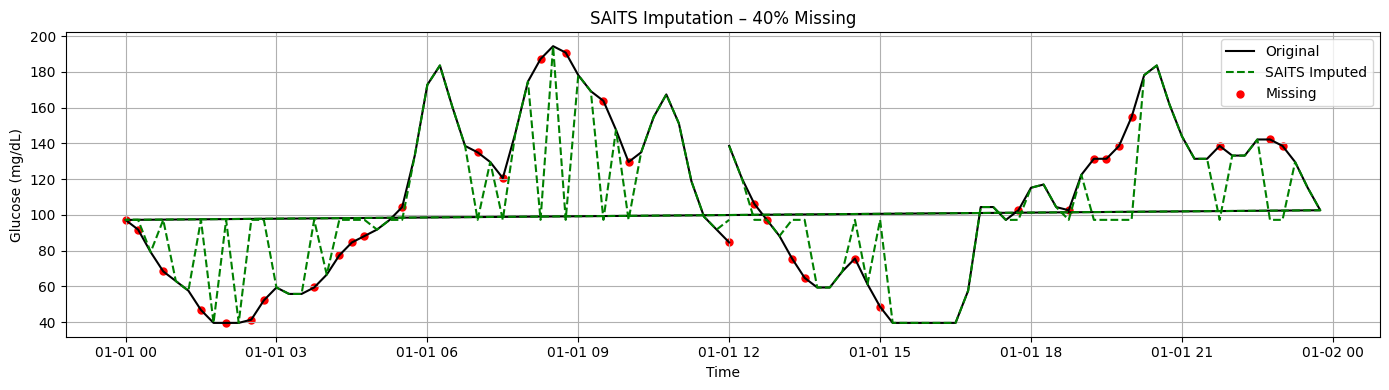


📊 SAITS Imputation Evaluation:


,Missingness,MAE,RMSE,MAPE,MAD,MRD
0,10% Missing,32.326739,36.383714,41.462474,32.326739,41.462474
1,20% Missing,36.251154,42.464232,46.398766,36.251154,46.398766
2,30% Missing,37.500000,43.989479,45.625250,37.500000,45.625250
3,40% Missing,33.088235,40.490048,38.400352,33.088235,38.400352


In [ ]:
# ✅ Colab-ready SAITS-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data
def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file, na_values=["", " "])
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')

    values = df['Blood Sugar Level'].values.astype(float)
    mask = ~np.isnan(values)
    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)
    return norm, mask.astype(float), mean, std, df['Time'].values

def to_tensor(data, mask):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device)

# STEP 5: Define SAITS model (simplified self-attention-based imputer)
class SAITS(nn.Module):
    def __init__(self, input_size=1, d_model=64, n_heads=4, num_layers=2):
        super(SAITS, self).__init__()
        self.embedding = nn.Linear(input_size * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)

    def forward(self, x, mask):
        inp = torch.cat([x, mask], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Train function with block missingness
import random

def simulate_block_mask(mask, block_size=12):
    new_mask = mask.copy()
    for _ in range(5):
        start = random.randint(0, len(mask) - block_size)
        new_mask[start:start+block_size] = 0
    return new_mask

def train_model(model, x_full, mask_full, epochs=200):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        train_mask = mask_full.clone().squeeze(0).squeeze(1).cpu().numpy()
        train_mask = simulate_block_mask(train_mask)
        train_mask = torch.tensor(train_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function
def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor = to_tensor(x_raw, mask)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing

    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='SAITS Imputed', color='green', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"SAITS Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train = to_tensor(train_data, train_mask)
model = SAITS().to(device)
train_model(model, x_train, m_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 SAITS Imputation Evaluation:")
display(results_df)
